In [108]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import OneHotEncoder

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense

import pylab as pl
import pandas as pd
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

os.environ['KMP_DUPLICATE_LIB_OK']='True'


Using TensorFlow backend.


In [88]:
def list_files(startpath, return_neutral = False):

    all_files = []
    neutral_files = []
    for root, dirs, files in os.walk(startpath):
        files = sorted(files)
        if files and files[-1][-4] == '.' and files[0][-4] == '.':
            all_files.append(root + '/' + files[-1])
            neutral_files.append(root + '/' + files[0])

    if return_neutral:
        return sorted(all_files), sorted(neutral_files)
    else:
        return sorted(all_files)

In [89]:
def find_matching(X, y):
    final_X = []
    final_y = []
    i, j = 0, 0
    while i < len(X):
        X_split = X[i].split('/')
        y_split = y[j].split('/')
        if X_split[3] == y_split[3] and X_split[4] == y_split[4]:
            final_X.append(X[i])
            final_y.append(y[j])
            j+=1
        i+=1
    return final_X, final_y

In [90]:
def read_Y(y):
    res_y = []
    for file in y:
        with open(file) as f:
            for line in f.readlines():
                res_y.append(float(line))
    return np.array(res_y)
    

In [91]:
def read_X(X):
    res_X = []
    try:
        for file in X:
            img = cv2.imread(file,1) # reads image as color
            img, bboxes = face_reduction(img)
            res_X.extend(img)
    except Exception as e:
        print("Exception in X")
        print(X)
        print(e)
    return np.array(res_X)

In [92]:
def detectFaceOpenCVDnn(net, frame):
    result = []
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], False, False)
    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    conf_threshold = 0.7
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            if x1 > frameWidth or x1 < 0 or x2 > frameWidth or x2 < 0 or y1 < 0 or y1 > frameHeight or y2 < 0 or y2 > frameHeight:
                continue
            else:
                grayOpenDnn = gray = cv2.cvtColor(frameOpencvDnn, cv2.COLOR_BGR2GRAY)
                croppedOpenDnn = cv2.resize(gray[y1:y2,x1:x2], (200,200)) 
                result.append(croppedOpenDnn)
#                 cv2.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return result, bboxes

In [93]:
def face_reduction(image):
    # OpenCV DNN supports 2 networks.
    # 1. FP16 version of the original caffe implementation ( 5.4 MB )
    # 2. 8 bit Quantized version using Tensorflow h( 2.7 MB )
#     print("printing image")
#     print(image)
    DNN = "TF"
    if DNN == "CAFFE":
        modelFile = "models/res10_300x300_ssd_iter_140000_fp16.caffemodel"
        configFile = "models/deploy.prototxt"
        net = cv2.dnn.readNetFromCaffe(configFile, modelFile)
    else:
        modelFile = "models/opencv_face_detector_uint8.pb"
        configFile = "models/opencv_face_detector.pbtxt"
        net = cv2.dnn.readNetFromTensorflow(modelFile, configFile)

    conf_threshold = 0.7
    outOpencvDnn, bboxes = detectFaceOpenCVDnn(net,image)
    return outOpencvDnn, bboxes

In [94]:
y_translation = {0:"neutral", 1:"anger", 2:"contempt", 3:"disgust", 4:"fear", 5:"happy", 6:"sadness", 7:"surprise"}
X, X_neutral = list_files('../Data/cohn-kanade-images/', return_neutral= True)
y = list_files('../Data/Emotion/')
X, y = find_matching(X, y)
y = read_Y(y)
X = read_X(X)
X_neutral = read_X(X_neutral)

X_train= np.vstack((X, X_neutral))
print(X_train.shape)
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],X_train.shape[2],1))
print(X_train.shape)
total_y = np.hstack((y, np.zeros(X_neutral.shape[0]))).reshape(-1,1)

print(total_y.shape)

oht = OneHotEncoder(categories='auto', sparse=False)
y_train = oht.fit_transform(total_y)
print("the total number of unique training points are: ")
np.unique(total_y, return_counts=True)
print(y_translation)

(906, 200, 200)
(906, 200, 200, 1)
the total number of unique training points are: 


(array([0., 1., 2., 3., 4., 5., 6., 7.]),
 array([583,  44,  17,  59,  24,  69,  27,  83]))

{0: 'neutral', 1: 'anger', 2: 'contempt', 3: 'disgust', 4: 'fear', 5: 'happy', 6: 'sadness', 7: 'surprise'}


## KERAS NEURAL NET

In [11]:
IMG_SIZE = 200
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
# model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(BatchNormalization())
# model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(8, activation = 'softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.fit(X_train, y_train, batch_size=50, epochs=20, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
906/906 [==============================] - 42s - loss: 4.4602 - acc: 0.6876    
Epoch 2/20
906/906 [==============================] - 39s - loss: 4.5872 - acc: 0.7130    
Epoch 3/20
906/906 [==============================] - 39s - loss: 4.4924 - acc: 0.7196    
Epoch 4/20
906/906 [==============================] - 40s - loss: 4.5030 - acc: 0.7196    
Epoch 5/20
906/906 [==============================] - 39s - loss: 4.4120 - acc: 0.7263    
Epoch 6/20
906/906 [==============================] - 44s - loss: 4.3942 - acc: 0.7274    
Epoch 7/20
906/906 [==============================] - 41s - loss: 4.3942 - acc: 0.7274    
Epoch 8/20
906/906 [==============================] - 39s - loss: 4.3944 - acc: 0.7274    
Epoch 9/20
906/906 [==============================] - 39s - loss: 4.6648 - acc: 0.7097    
Epoch 10/20
906/906 [==============================] - 40s - loss: 4.4489 - acc: 0.7230    
Epoch 11/20
906/906 [====================

In [13]:
def display_emotions(videoFaces, frame, bboxes):
    outputFrame = frame.copy()
    predictions = model.predict(videoFaces)
    for i in range(len(bboxes)):
        emotion = y_translation[np.argmax(predictions[i])]
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(outputFrame, emotion, (bboxes[i][0] -1 ,bboxes[i][1] - 1), font, 1, (0,255,0), 2, cv2.LINE_AA)
        cv2.rectangle(outputFrame, (bboxes[i][0], bboxes[i][1]), (bboxes[i][2], bboxes[i][3]), (0, 255, 0), int(round(outputFrame.shape[0]/150)), 8)
    return outputFrame

In [14]:
def get_webcam_feed():
    cap = cv2.VideoCapture(0)
    hasFrame, frame = cap.read()
    #TODO : Handle cases for multiple people
    frame_count = 0
    tt_opencvDnn = 0
    while(1):
        try:
            hasFrame, frame = cap.read()
            if not hasFrame:
                break
            frame_count += 1
            outputFrame = frame
            #Gives a list of gray-scale images in webcam feed
            videoFaces, bboxes = face_reduction(frame)
            videoFaces = np.array(videoFaces)
            if videoFaces.shape[0] != 0:
#                 print(videoFaces.shape)
                videoFaces = videoFaces.reshape((videoFaces.shape[0],videoFaces.shape[1],videoFaces.shape[2],1))
                outputFrame = display_emotions(videoFaces, frame, bboxes)
            cv2.imshow("frame", outputFrame)
            k = cv2.waitKey(10)
            if k == 27:
                break
        except Exception as e:
            print("Exception is ")
            print(e)
            break
    cv2.destroyAllWindows()

In [15]:
get_webcam_feed()

# MultiClass SVM

In [98]:
# Starting SVM 
from sklearn.svm import SVC
# data preprocessing

X_train_new = np.reshape(X_train, (X_train.shape[0], (X_train.shape[1]*X_train.shape[2]*X_train.shape[3])))
print(X_train_new.shape)
y_train_new = []
print(len(y_train))
for i in range(len(y_train)):
    index = np.nonzero(y_train[i])[0]
    y_train_new.append(index)
y_train_new = np.array(y_train_new)
print(y_train_new.shape)

(906, 40000)
906
(906, 1)


44
17
59
24
69
27
83
583
(906, 40000)
[38.93156733 38.44812362 38.03311258 37.54415011 37.02207506 36.64790287
 36.31898455 35.84547461 35.51766004 35.28476821]
(906, 40000)


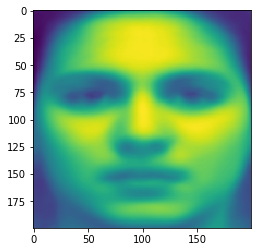

In [101]:
print(np.count_nonzero(y_train_new == 1))
print(np.count_nonzero(y_train_new == 2))
print(np.count_nonzero(y_train_new == 3))
print(np.count_nonzero(y_train_new == 4))
print(np.count_nonzero(y_train_new == 5))
print(np.count_nonzero(y_train_new == 6))
print(np.count_nonzero(y_train_new == 7))
print(np.count_nonzero((y_train_new == 0)))

print(X_train_new.shape)

mean_image = np.mean(X_train_new, axis=0)
print(mean_image[:10])

print(X_train_new.shape)

plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((200,200)))
plt.show()

In [ ]:
X_train_new = np.array(X_train_new, dtype = mean_image.dtype)
X_train_new -= mean_image

In [105]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()

#encoding train labels
encoder.fit(y_train_new)
y_train_new = encoder.transform(y_train_new)



[3 7 1 5 7 6 4 1 3 5 7 6 1 5 7 1 3 7 6 1 5 1 1 7 1 4 3 5 7 1 5 7 3 5 7 1 5
 7 6 1 5 7 5 3 3 1 6 7 4 3 4 7 1 5 7 3 7 5 3 7 5 4 7 3 7 3 1 5 4 3 7 5 7 3
 5 7 1 3 7 4 5 7 3 7 5 3 4 7 5 3 7 5 7 5 6 4 7 5 3 7 5 6 1 7 1 5 3 5 7 4 3
 7 3 5 7 5 3 7 6 1 5 3 1 5 7 3 4 7 3 5 7 3 5 1 7 3 5 7 3 7 5 3 7 3 5 7 6 3
 7 6 3 7 1 3 5 7 4 5 7 3 7 5 7 3 5 1 7 3 7 5 1 7 3 1 4 5 7 1 5 6 5 7 5 7 3
 5 6 7 3 5 7 3 5 3 5 7 5 3 7 1 5 7 7 4 3 3 6 3 5 7 3 6 3 5 1 3 5 7 7 1 3 1
 7 6 1 7 5 7 6 5 7 3 5 7 4 1 7 4 1 7 7 4 3 5 6 5 4 7 3 7 1 7 5 1 3 5 7 1 3
 5 7 1 6 3 5 7 6 5 3 6 4 3 5 7 1 7 5 1 5 3 7 5 7 6 1 5 7 6 5 4 7 5 6 2 2 2
 2 2 2 2 2 2 2 2 2 1 4 6 1 2 4 1 2 6 1 2 4 6 2 6 1 2 4 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [107]:
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [109]:
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train_new, y_train_new)

/home/jatin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kernel': ['rbf'], 'gamma': [0.001, 0.0001], 'C': [1, 10, 100, 1000]}, {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [111]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

Best score for training data: 0.8167770419426048 

Best C: 1 

Best Kernel: linear 

Best Gamma: auto_deprecated 



In [115]:
svm_model.predict(X_train_new[0].reshape(1,40000))

array([3])

In [117]:
def new_display_emotions(videoFaces, frame, bboxes):
    outputFrame = frame.copy()
    predictions = svm_model.predict(videoFaces)
    for i in range(len(bboxes)):
        emotion = y_translation[predictions[i]]
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(outputFrame, emotion, (bboxes[i][0] -1 ,bboxes[i][1] - 1), font, 1, (0,255,0), 2, cv2.LINE_AA)
        cv2.rectangle(outputFrame, (bboxes[i][0], bboxes[i][1]), (bboxes[i][2], bboxes[i][3]), (0, 255, 0), int(round(outputFrame.shape[0]/150)), 8)
    return outputFrame

In [124]:
def new_get_webcam_feed():
    cap = cv2.VideoCapture(0)
    hasFrame, frame = cap.read()
    #TODO : Handle cases for multiple people
    frame_count = 0
    tt_opencvDnn = 0
    while(1):
        try:
            hasFrame, frame = cap.read()
            if not hasFrame:
                break
            frame_count += 1
            outputFrame = frame
            #Gives a list of gray-scale images in webcam feed
            videoFaces, bboxes = face_reduction(frame)
            videoFaces = np.array(videoFaces)
            if videoFaces.shape[0] != 0:
#                 print(videoFaces.shape)
                videoFaces = videoFaces.reshape((videoFaces.shape[0],videoFaces.shape[1],videoFaces.shape[2],1))
                videoFaces = np.reshape(videoFaces, (videoFaces.shape[0], (videoFaces.shape[1]*videoFaces.shape[2]*videoFaces.shape[3])))
                outputFrame = new_display_emotions(videoFaces, frame, bboxes)
            cv2.imshow("frame", outputFrame)
            k = cv2.waitKey(10)
            if k == 27:
                break
        except Exception as e:
            print("Exception is ")
            print(e)
            break
    cv2.destroyAllWindows()

In [125]:
new_get_webcam_feed()